# 專題

# 基本目標

- 爬下文章，透過 jieba 等斷詞將文章拆解
- 可以簡單的計算同樣文字出現的頻率或是透過 TFIDF 的統計方式計算
- 將經常出現的 stop words 過濾掉之後對頻率進行排名
- 將結果透過 wordcloud 文字雲的方式呈現


# 進階目標

- 透過不同帳號，但是相同 IP 且政治用語的詞頻分佈類似的定位成網軍
- 進一步分析帳號是否在特定期間 (e.g. 選舉) 有明顯的活動特性
- 如果不同帳號但是政治用語的詞頻分佈類似，進一步判斷這些高頻率的單字是positive / negative 來歸納兩個帳號之間是否具有相同政治立場



In [1]:
import requests
import re
import json
import jieba
import pandas as pd
import matplotlib.pyplot as plt
import _thread
import time
from datetime import datetime
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from urllib.parse import urljoin
from bs4 import BeautifulSoup

# PTT 八卦版網址
#PTT_URL = 'https://www.ptt.cc/bbs/Gossiping/index.html'
#PTT_URL = 'https://www.ptt.cc/bbs/Gossiping/index27901.html'
PTT_URL = 'https://www.ptt.cc/bbs/HatePolitics/index.html'
url_host = 'https://www.ptt.cc'
# 爬取文章數
maxCount=20

In [2]:
# 設定停用詞
stopwords = []
with open('stopwords-master/cn_stopwords.txt', 'r', encoding='utf-8') as f:
    for line in f:
        if len(line)>0:
            stopwords.append(line.strip())
            
# 設定網軍詞
political = []
with open('mgck2017/政黑_繁體.txt', 'r', encoding='utf-8') as f:
    for line in f:
        if len(line)>0:
            political.append(line.strip())    

#Jieba

In [3]:
regStr = '\s+|[0-9a-zA-Z_\{\}\(\)（）\./:~\=]+'
#計算結巴字詞的個數
def jiebaCount(data,content):
    jieba.set_dictionary('dict.user.big.txt')
    words = jieba.cut(content, cut_all=False)
    #regex = re.compile('\W|\s+')
    global regStr
    regex = re.compile(regStr)
    for word in words:
            if not regex.match(word) and word not in stopwords:
                if word in data:
                    count=data[word]+1
                    tmp={}
                    tmp={word:count}
                    data.update(tmp)
                else:
                    data[word]=1
                
    return data


#計算結巴字詞的個數
def jiebaContentWithTFIDF(wordSet,content):
    global stopwords
    jieba.set_dictionary('dict.user.big.txt')
    words = jieba.cut(content, cut_all=False)
    wordContentList = list()
    global regStr
    #regex = re.compile('\s+|w+')
    regex = re.compile(regStr)
    for word in words:
            if  not regex.match(word):
                #if word not in wordSet:
                #    print(word)
                
                #print(stopwords)
                if word not in wordSet and word not in stopwords:
                    wordSet.add(word)
                    
                if word not in wordContentList and word not in stopwords:
                    wordContentList.append(word)
                    
    return wordSet,wordContentList;

#TF-IDF

In [4]:
def computeTF(wordDict, bagOfWords):
    tfDict = {}
    bagOfWordsCount = len(bagOfWords)
    for word, count in wordDict.items():
        tfDict[word] = count / float(bagOfWordsCount)
    return tfDict

In [5]:
def computeIDF(documents):
    import math
    N = len(documents)
    
    idfDict = dict.fromkeys(documents[0].keys(), 0)
    for document in documents:
        for word, val in document.items():
            if val > 0:
                idfDict[word] += 1
    
    for word, val in idfDict.items():
        idfDict[word] = math.log(N / float(val))
    return idfDict

In [6]:
def computeTFIDF(tfBagOfWords, idfs):
    tfidf = {}
    for word, val in tfBagOfWords.items():
        tfidf[word] = val * idfs[word]
    return tfidf

In [7]:
def filterIP(ipTemp):
    pattern_1 = re.compile('(\d{1,3}).(\d{1,3}).(\d{1,3}).(\d{1,3})')
    pattern_2 = re.compile('^(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)$')
    result_1 = re.search(pattern_1, ipTemp)
    result_2 = re.search(pattern_2, result_1.group())
    if result_2:
        return result_2.group()
    else:
        print(ipTemp,'is No Match')
    

- 爬下文章，透過 jieba 等斷詞將文章拆解


In [8]:
def crawl_article(url):
    response = requests.get(url, cookies={'over18': '1'})
    #print(response)
    # 假設網頁回應不是 200 OK 的話, 我們視為傳送請求失敗
    if response.status_code != 200:
        print('Error - {} is not available to access'.format(url))
        return
    
    # 將網頁回應的 HTML 傳入 BeautifulSoup 解析器, 方便我們根據標籤 (tag) 資訊去過濾尋找
    soup = BeautifulSoup(response.text)

    # 取得文章內容主體
    main_content = soup.find(id='main-content')
    
    # 假如文章有屬性資料 (meta), 我們在從屬性的區塊中爬出作者 (author), 文章標題 (title), 發文日期 (date)
    metas = main_content.select('div.article-metaline')
    author = ''
    title = ''
    date = ''
    if metas:
        if metas[0].select('span.article-meta-value')[0]:
            author = metas[0].select('span.article-meta-value')[0].string
        if metas[1].select('span.article-meta-value')[0]:
            title = metas[1].select('span.article-meta-value')[0].string
        if metas[2].select('span.article-meta-value')[0]:
            date = metas[2].select('span.article-meta-value')[0].string

        # 從 main_content 中移除 meta 資訊（author, title, date 與其他看板資訊）
        #
        # .extract() 方法可以參考官方文件
        #  - https://www.crummy.com/software/BeautifulSoup/bs4/doc/#extract
        for m in metas:
            m.extract()
        for m in main_content.select('div.article-metaline-right'):
            m.extract()
    
    # 取得留言區主體
    pushes = main_content.find_all('div', class_='push')
    for p in pushes:
        p.extract()
    
    # 假如文章中有包含「※ 發信站: 批踢踢實業坊(ptt.cc), 來自: xxx.xxx.xxx.xxx」的樣式
    # 透過 regular expression 取得 IP
    # 因為字串中包含特殊符號跟中文, 這邊建議使用 unicode 的型式 u'...'
    try:
        ip = main_content.find(text=re.compile(u'※ 發信站:'))
        ip = re.search('[0-9]*\.[0-9]*\.[0-9]*\.[0-9]*', ip).group()
    except Exception as e:
        ip = ''
    
    # 移除文章主體中 '※ 發信站:', '◆ From:', 空行及多餘空白 (※ = u'\u203b', ◆ = u'\u25c6')
    # 保留英數字, 中文及中文標點, 網址, 部分特殊符號
    #
    # 透過 .stripped_strings 的方式可以快速移除多餘空白並取出文字, 可參考官方文件 
    #  - https://www.crummy.com/software/BeautifulSoup/bs4/doc/#strings-and-stripped-strings
    filtered = []
    for v in main_content.stripped_strings:
        # 假如字串開頭不是特殊符號或是以 '--' 開頭的, 我們都保留其文字
        if v[0] not in [u'※', u'◆'] and v[:2] not in [u'--']:
            filtered.append(v)

    # 定義一些特殊符號與全形符號的過濾器
    expr = re.compile(u'[^一-龥。；，：“”（）、？《》\s\w:/-_.?~%()]')
    for i in range(len(filtered)):
        filtered[i] = re.sub(expr, '', filtered[i])
    
    # 移除空白字串, 組合過濾後的文字即為文章本文 (content)
    filtered = [i for i in filtered if i]
    content = ' '.join(filtered)
    
    # 處理留言區
    # p 計算推文數量
    # b 計算噓文數量
    # n 計算箭頭數量
    p, b, n = 0, 0, 0
    messages = []
    for push in pushes:
        # 假如留言段落沒有 push-tag 就跳過
        if not push.find('span', 'push-tag'):
            continue
        
        # 過濾額外空白與換行符號
        # push_tag 判斷是推文, 箭頭還是噓文
        # push_userid 判斷留言的人是誰
        # push_content 判斷留言內容
        # push_ipdatetime 判斷留言日期時間
        push_tag = push.find('span', 'push-tag').string.strip(' \t\n\r')
        push_userid = push.find('span', 'push-userid').string.strip(' \t\n\r')
        push_content = push.find('span', 'push-content').strings
        push_content = ' '.join(push_content)[1:].strip(' \t\n\r')
        push_ipdatetime = push.find('span', 'push-ipdatetime').string.strip(' \t\n\r')

        # 整理打包留言的資訊, 並統計推噓文數量
        messages.append({
            'push_tag': push_tag,
            'push_userid': push_userid,
            'push_content': push_content,
            'push_ipdatetime': push_ipdatetime})
        if push_tag == u'推':
            p += 1
        elif push_tag == u'噓':
            b += 1
        else:
            n += 1
    
    # 統計推噓文
    # count 為推噓文相抵看這篇文章推文還是噓文比較多
    # all 為總共留言數量 
    message_count = {'all': p+b+n, 'count': p-b, 'push': p, 'boo': b, 'neutral': n}
    
    # 整理文章資訊
    data = {
        'url': url,
        'article_author': author,
        'article_title': title,
        'article_date': date,
        'article_content': content,
        'ip': ip,
        'message_count': message_count,
        'messages': messages
    }
    return data

In [9]:
resp = requests.get(PTT_URL, cookies={'over18': '1'})
soup = BeautifulSoup(resp.text)
count=0 #計算文章數
all_data=[]
#PTT_URL='https://www.ptt.cc/bbs/Gossiping/index39052.html'
while count<maxCount:
    # 對文章列表送出請求並取得列表主體
    if count>0:
        PTT_URL=url_host+soup.find(id='action-bar-container').find_all('a',class_='wide')[1].get('href')
        
    resp = requests.get(PTT_URL, cookies={'over18': '1'})
    soup = BeautifulSoup(resp.text)
    main_list = soup.find('div', class_='bbs-screen')
    #nextPage=soup.find(id='action-bar-container').find_all('a',class_='wide')[1].get('href')

    #count=0 #計算文章數
    # 依序檢查文章列表中的 tag, 遇到分隔線就結束, 忽略這之後的文章
    for div in main_list.findChildren('div', recursive=False):
        #print('poncc-start:',count,class_name)
        class_name = div.attrs['class']
        # 遇到分隔線要處理的情況
        if class_name and 'r-list-sep' in class_name:
            #print('Reach the last article')
            break
        # 遇到目標文章
        if class_name and 'r-ent' in class_name:
            div_title = div.find('div', class_='title')
            a_title = div_title.find('a', href=True)
            # 排除已刪除或違反版規貼文
            if a_title==None:
                #print('poncc-debug-title:',count)
                continue
                
            article_URL = urljoin(PTT_URL, a_title['href'])
            article_title = a_title.text
            print('Parse-{} {} - {}'.format(count,article_title, article_URL))

            # 呼叫上面寫好的 function 來對文章進行爬蟲
            parse_data = crawl_article(article_URL)
        
            # 將爬完的資料儲存
            all_data.append(parse_data)
            
            # 呼叫上面寫好的 function 來對文章中的字詞進行爬蟲與計數
            #authorInfo,wordSet,tmp = crawl_article(authorInfo,stopwords,wordSet,article_URL)
            #wordContentList[count]=tmp
            count+=1;
        #第n篇文章結束   
        if count>=maxCount:
            print('end')
            break;
#print('poncc-cout:',count)


Parse-0 [新聞] 縣市首長防疫表現 侯友宜第一.鄭文燦第二 - https://www.ptt.cc/bbs/HatePolitics/M.1587916239.A.CE4.html
Parse-1 [討論] 談一下柯粉網軍和slow網軍差異 - https://www.ptt.cc/bbs/HatePolitics/M.1587916540.A.6DF.html
Parse-2 [新聞] 桃市5月1日裁撤10條免費公車路線引反彈 試辦316路公車  - https://www.ptt.cc/bbs/HatePolitics/M.1587916616.A.5BF.html
Parse-3 [討論] 這次火災責任歸屬誰要來扛 - https://www.ptt.cc/bbs/HatePolitics/M.1587916726.A.401.html
Parse-4 Re: [討論] 這次火災責任歸屬誰要來扛 - https://www.ptt.cc/bbs/HatePolitics/M.1587917121.A.62F.html
Parse-5 Re: [討論] 八卦版集體噓爆也太好笑XD  - https://www.ptt.cc/bbs/HatePolitics/M.1587917560.A.492.html
Parse-6 [討論] 原來柯文哲過了五小時才到 唉 - https://www.ptt.cc/bbs/HatePolitics/M.1587917800.A.83A.html
Parse-7 [新聞] 六都防疫民調他最強 居然還贏鄭文燦   - https://www.ptt.cc/bbs/HatePolitics/M.1587917840.A.2D7.html
Parse-8 Re: [新聞] 不要煽風點火 民眾黨正妹發言人戰王浩宇 - https://www.ptt.cc/bbs/HatePolitics/M.1587918324.A.5E6.html
Parse-9 [討論] 震撼！柯粉：這次火災台北市政府很完美 - https://www.ptt.cc/bbs/HatePolitics/M.1587918714.A.479.html
Parse-10 Re: [討論] 震撼！柯粉：這次火災台北市政府很完美 - https://www.ptt

In [10]:
# 將爬完的資訊存成 json 檔案
with open('parse_data.json', 'w+') as f:
    json.dump(all_data, f, ensure_ascii=False, indent=4)

#讀取json

In [11]:
wordSet=set()
wordCount=dict()
authorInfo=dict()
wordContentList=dict(list())

with open('parse_data.json') as json_file:
    data = json.load(json_file)
    for index,d in enumerate(data):
        #print(d['article_content'])
        wordCount=jiebaCount(wordCount,d['article_content'])
        wordSet,tempList=jiebaContentWithTFIDF(wordSet,d['article_content'])
        wordContentList[index]=tempList
#print(wordContentList)

Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.122 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.124 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.144 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawl

Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.126 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.130 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.111 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph00

In [12]:
#print(wordContentList

#將字詞和文章分開，計算權重

In [13]:
tfList=list()
tfidfList=list()
#計算TF
#print(wordContentList)
for i in range(maxCount):
    numOfWords = dict.fromkeys(wordSet, 0)
    for word in wordContentList[i]:
        numOfWords[word] += 1
    tfList.append(computeTF(numOfWords, wordContentList[i]))

#計算IDF
idfs = computeIDF(tfList)
#print(tfList[2])
for tf in tfList:
    tfidfList.append(computeTFIDF(tf, idfs))
    
dataframe = pd.DataFrame(tfidfList)
dataframe

,成績,阿北,偷跑,障礙者,未依,民眾,崩潰,批評,空戰,娛樂場所,...,變成,施政,想要,交通局,參與,僱傭,認為,引起,倒,公司
0,0.016281,0.00000,0.000000,0.000000,0.000000,0.007534,0.000000,0.016281,0.000000,0.000000,...,0.00000,0.016281,0.000000,0.000000,0.016281,0.00000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.048991,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.00000,0.000000,0.016925,0.000000,0.007832,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.016925,0.000000,0.00000,0.000000,0.016925,0.000000,0.000000
3,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.08811,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.08811,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.031869,0.000000,0.000000,0.000000
6,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.00000,0.000000,0.000000,0.000000,0.017115,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.00000,0.000000,0.000000,0.000000,0.011271,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.024356,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.079399,0.000000


#文字雲

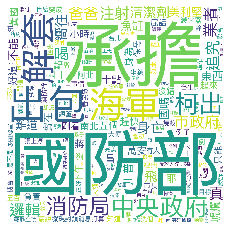

In [24]:
tfidfMerge=dict()
#for d in tfidfList:
#    tfidfMerge.update(d)

tfidfMerge=dict()
for d in tfidfList:
    for k,v in d.items():
        if k in tfidfMerge:
            if tfidfMerge[k]<v:
                tfidfMerge[k]=v
        else:
            tfidfMerge[k]=v

tfidfMerge={k: v for k, v in sorted(tfidfMerge.items(), key=lambda item: item[1],reverse=True)}

#print(type(tfidfList[0]))
font_path="/System/Library/fonts/PingFang.ttc"
wordcloud = WordCloud(background_color="white",font_path=font_path,width=1000,height=1000,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(tfidfMerge)

#wordcloud = WordCloud(background_color="white",width=1000, height=860, margin=2).generate("Ob Bc debugC")
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('wordCloud.png',dpi=100)
plt.show()

#以字數計算

dict_keys(['柯文哲', '市長', '台灣', '防疫', '路線', '市民', '施工', '真的', '一個', '公車', '發生', '台北', '月', '消防', '表現', '什麼', '台北市', '民眾', '陳', '蘆竹'])


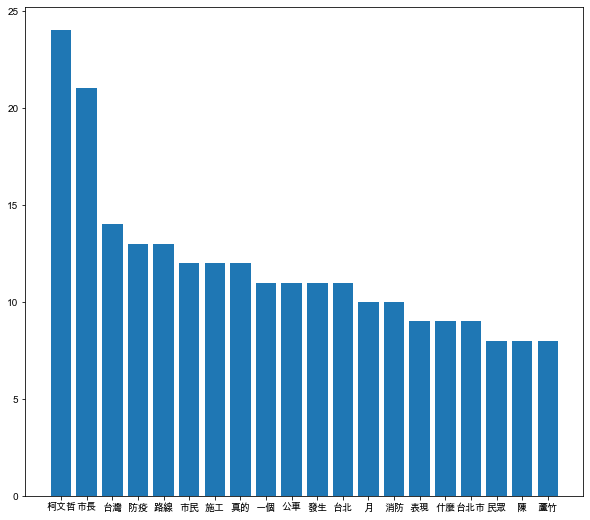

In [22]:

wordCount={k: v for k, v in sorted(wordCount.items(), key=lambda item: item[1],reverse=True)}

count=0;
rankMax=20;
wordCount_rank=dict()
for k,v in wordCount.items():
    if count<rankMax:
        #print(k)
        wordCount_rank[k]=v
        count+=1
    else:
        break;

keys = wordCount_rank.keys()
values = wordCount_rank.values()
print(keys)

plt.figure(figsize=(10,9))
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

plt.bar(keys, values)
plt.savefig('wordBar.png',dpi=100)

In [16]:
#整理政黑資料
index=0
for d in tfidfList:
    for k,v in d.items():
        if v>0 and k in political:
            temp=dict()
            authorInfo[index].update({k:v})
    index+=1

KeyError: 8

#網軍判斷

In [ ]:
political_max = 1
political_info = dict(list(dict()))

#判斷政治用語詞頻分佈
for index in authorInfo:
    #print(len(authorInfo[index]),authorInfo[index]['ip'])
    if len(authorInfo[index]) > political_max:
        ip=authorInfo[index]['ip']
        author=authorInfo[index]['author']
        url=authorInfo[index]['url']
        if ip in political_info:
            if author not in political_info[ip][0].values():
                print('ponccQQ',ip,author,':',political_info[ip])
                tempList=political_info[ip];
                tempList.append({'author':author,'url':url,'count':len(authorInfo[index])})
                political_info[ip]=tempList
            else:
                tempList=political_info[ip];
                tempList.append({'author':author,'url':url,'count':len(authorInfo[index])})
                political_info[ip]=tempList
        else:    
            tempList=list()
            tempList.append({'author':author,'url':url,'count':len(authorInfo[index])})
            political_info[ip] = tempList
    #for k,v in authorInfo[index].items():
    #    if k in political:
    #        x=1
#            print(k)
for i in political_info:
    #print(len(political_info[i]))
    if len(political_info[i]) > 1:
        for l in political_info[i]:
            print('網軍:',i,'count:',len(political_info[i]),'info:',l['author'],l['url'])
political_info

In [ ]:
x = ['张三', '李四', '-1']
y = [1, 2, 3]
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.plot(x, y)
plt.show()

In [ ]:

#datetime.strptime("Wed Jan 22 10:18:48 2020", "%a %b %d %H:%m:%S %d")
s=datetime.strptime("Wed Jan 22 10:18:48 2020", "%a %b %d %H:%M:%S %Y")
#s = datetime.strptime("2018-01-31", "%Y-%m-%d")
print(s)

In [ ]:

#tempList=list();
#tempList=[1:2]